In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [96]:
def amean(da,cf=1/365):
    #annual mean
    m  = da['time.daysinmonth']
    xa = cf*(m*da).groupby('time.year').sum().compute()
    return xa

In [2]:
def fix_time(ds):
    yr0=str(ds['time.year'][0].values)
    nt=len(ds.time)
    ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug
    return ds

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [7]:
d='/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/'
f='PPEn11_transient_LHC{}.clm2.{}.{}-02-01-00000.nc'


In [20]:
def pp(ds):
    dvs=['GPP','TOTVEGC']
    return fix_time(ds[dvs])

In [61]:
def pp0(ds):
    dvs=['TBOT','QBOT','WIND','SNOW','RAIN','PBOT','FSDS','FLDS']
    return fix_time(ds[dvs])

In [65]:
#only need one h0 member, because they should all be the same
h0files=[d+f.format('0000','h0','2005') for yy in range(2005,2015,5)]
ds0=fix_time(xr.open_mfdataset(h0files,combine='nested',concat_dim='time',preprocess=pp0)) 
tmp=xr.open_dataset(h0files[0])
for v in tmp:
    if 'grid1d' in v:
        ds0[v]=tmp[v]

In [66]:
#read in some h1 data
yy='2005'
h1files=[d+f.format(str(i).zfill(4),'h1',yy) for i in range(1,501)]
ds1=xr.open_mfdataset(h1files,combine='nested',concat_dim='ens',
                      parallel=True,preprocess=pp)
tmp=xr.open_dataset(h1files[0])
for v in tmp:
    if 'pfts1d' in v:
        ds1[v]=tmp[v]

In [88]:
#create the gc_to_pft indexer
latlon_gc=ds0.grid1d_jxy*1000+ds0.grid1d_ixy
gkey={g:i for i,g in enumerate(latlon_gc.values)}
latlon_pft=ds1.pfts1d_jxy*1000+ds1.pfts1d_ixy
gc_to_pft=xr.DataArray([gkey[p] for p in latlon_pft.values],dims='pft')

In [89]:
dvs=['TBOT','QBOT','WIND','SNOW','RAIN','PBOT','FSDS','FLDS']
for v in dvs:
    ds1[v]=ds0[v].isel(gridcell=gc_to_pft).compute()

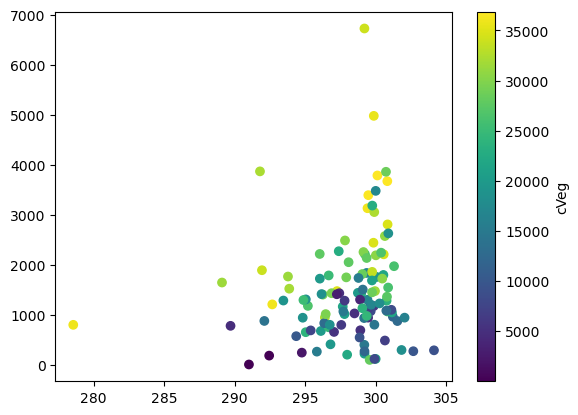

In [92]:
ixpft=ds1.pfts1d_itype_veg==4
cf=24*60*60*365 #mm/yr
plt.scatter(ds1.TBOT.isel(pft=ixpft).mean(dim='time'),
            cf*(ds1.RAIN+ds1.SNOW).isel(pft=ixpft).mean(dim='time'),
            c=ds1.TOTVEGC.isel(pft=ixpft,ens=0).mean(dim='time'))
plt.colorbar(label='cVeg');